## Task1:Hough Line Transformation

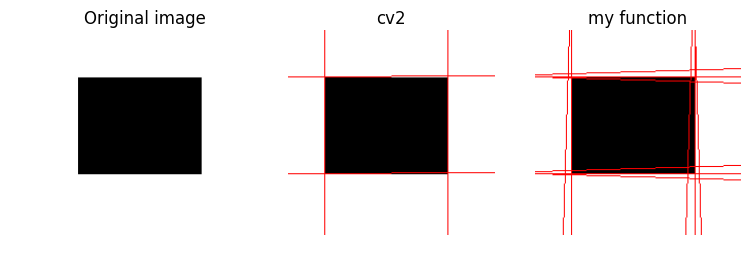

--- 2.870590925216675 seconds ---


In [31]:
import matplotlib.pyplot as plt
from skimage import data
import numpy as np
import cv2 as cv
import scipy
from PIL import Image
from skimage.transform import resize
from ipywidgets import interact, fixed, FloatSlider, IntSlider,FloatRangeSlider, Label
np.set_printoptions(threshold=np.nan)
import math
import time
def my_HoughLines(input_image,rho_resolution,theta_resolution,threshold):
    start_time = time.time()
    
    #applying canny edget detector
    edges = cv.Canny(input_image,50,150,apertureSize =3)
    nrows = edges.shape[0]
    ncol = edges.shape[1]
    
    #getting the edges positions
    xx,yy = np.where(edges>0)
    
    D = np.ceil(np.sqrt((nrows)**2 + (ncol)**2))
    nrho = 2*rho_resolution
    rho_scale = np.linspace(-D,D,nrho)
    theta_range = np.linspace(1*(np.pi/180),180*(np.pi/180),theta_resolution)
    theta_cos= np.cos(theta_range)
    theta_sin= np.sin(theta_range)
    
    #intializing the accumulator
    accumulator = np.zeros((len(rho_scale),len(theta_range)))
    output_image = np.empty((nrows,ncol, 3))
    output_image_2 = np.empty((nrows,ncol, 3))
    
    #built HoughLines transformation in opencv
    lines = cv.HoughLines(edges,1,np.pi/180,threshold)
    
    max_size=max(nrows,ncol)**2
    output_image[:, :, 2] =  output_image[:, :, 1] =  output_image[:, :, 0] =  input_image/255.
    output_image_2[:, :, 2] =  output_image_2[:, :, 1] =  output_image_2[:, :, 0] =  input_image/255.
    
    for angle in range(0,len(theta_range)):
        rho = xx*((theta_cos[angle]))+yy*(theta_sin[angle])
        #rho_ind = np.min(np.abs(rho_scale-rho))
        for l in range(0,len(rho)):
            rho_ind = np.nonzero(np.abs(rho_scale-rho[l]) == np.min(np.abs(rho_scale-rho[l])))[0]
            accumulator[rho_ind,angle]=accumulator[rho_ind,angle]+1
   
    #getting index where accumulator value is >= threshold value
    c,d  = np.where(accumulator>=threshold)
    list3 = [list(a) for a in zip(rho_scale[c], theta_range[d])]
   
    # creating and displaying lines detected from opencv function
    if lines is not None:
        for rho_theta in lines:
            rho=rho_theta[0][0]
            theta=rho_theta[0][1]
            a = np.cos(theta)
            b = np.sin(theta)
            x0 = a*rho
            y0 = b*rho
            x1 = int(x0 + max_size*(-b))
            y1 = int(y0 + max_size*(a))
            x2 = int(x0 - max_size*(-b))
            y2 = int(y0 - max_size*(a))
            cv.line(output_image,(x1,y1),(x2,y2),(1,0,0),1)

    
    # creating and displaying lines detected from my function
    if list3 is not None:
        for rho_theta in list3:
            rho=(rho_theta[0])
            theta=rho_theta[1]
            #print(rho)
            #print(theta)
            a = np.cos(theta)
            b = np.sin(theta)
            x0 = a*rho
            y0 = b*rho
            x1 = int(x0 + max_size*(-b))
            y1 = int(y0 + max_size*(a))
            x2 = int(x0 - max_size*(-b))
            y2 = int(y0 - max_size*(a))
            cv.line(output_image_2,(y1,x1),(y2,x2),(1,0,0),1)

    #displaying the images
    fig1, axes_array = plt.subplots(1, 3)
    fig1.set_size_inches(9,3)
    image_plot = axes_array[0].imshow(input_image,cmap=plt.cm.gray) 
    axes_array[0].axis('off')
    axes_array[0].set(title='Original image')
    image_plot = axes_array[1].imshow(output_image)
    axes_array[1].axis('off')
    axes_array[1].set(title='cv2')
    image_plot = axes_array[2].imshow(output_image_2)
    axes_array[2].axis('off')
    axes_array[2].set(title='my function')
    plt.show()
    print("--- %s seconds ---" % (time.time() - start_time))
    
'''
Loading image: for better observation you can use custom image used
               in try block.With checkerboard image it may take
               upto 40 seconds depending on the resolution used
'''      
    
#img = data.checkerboard()
try:
    pil_im = Image.open('Tayyab_02_02.jpg').convert('L')
    img = pil_im.resize((200,200))
    img= np.asarray(img)
    th = 86
except FileNotFoundError:
    img = data.checkerboard()
    th = 185

interact(my_HoughLines,input_image=fixed(img),
         rho_resolution=IntSlider(min=10, max=1000, step=1,value =100,continuous_update=False),
        theta_resolution=IntSlider(min=10, max=1000, step=1,value = 180,continuous_update=False),
        threshold=IntSlider(min=5, max=1000, step=1,value = th,continuous_update=False)); 
    

## Task2: Circular Hough Transformation

C:\Program Files\Anaconda3\lib\site-packages\ipykernel\__main__.py:55: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


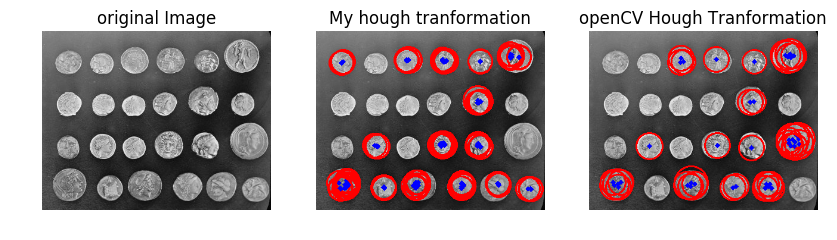

--- 16.874426126480103 seconds ---


In [32]:
import matplotlib.pyplot as plt
from PIL import Image
from skimage import data
from skimage.transform import resize
import numpy as np
import cv2 as cv
import scipy
import time
import math
from ipywidgets import interact, fixed, FloatSlider, IntSlider,IntRangeSlider, Label


def my_HoughCircles(img,threshold,lowerRadius,higherRadius,resolution):
    start_time = time.time()
    
    #applying canny edge detector 
    edges = cv.Canny(img,50,150,apertureSize =3)
    
    lRad = lowerRadius
    hRad = higherRadius
    Rad = np.linspace(lRad,hRad,2*(hRad-lRad+1))

    #getting the edges positions 
    xx,yy = np.where(edges>0)
    
    '''
    Randomly choosing 50 percent of edges to work with.
    This is done to make implementation faster.You can use all the edges
    by replacing 0.5 by 1.
    '''
    sample = np.random.randint(len(xx), size=math.ceil(0.5*len(xx)))
    xx =xx[sample]
    yy =yy[sample]
    
    row = edges.shape[0]
    col = edges.shape[1]

    A = np.linspace(0,row,2*(row+1))
    B = np.linspace(0,col,2*(row+1))
    
    #Initializing accumulator
    accumulator = np.zeros(shape=(len(A)+4*(hRad),len(B)+4*(hRad),200+len(Rad)))
    cimg = cv.cvtColor(img,cv.COLOR_GRAY2BGR)
    cimg2 = cv.cvtColor(img,cv.COLOR_GRAY2BGR)
    theta = np.linspace(1,360,360)
    
    #caching the values of cosine and sine for give theta
    theta_cos= np.cos(theta*(math.pi/180))
    theta_sin= np.sin(theta*(math.pi/180))

    for j in range(0,len(Rad)):
        for t in range(0,len(theta)):
            a = xx-math.ceil(Rad[j]*theta_cos[t])
            b = yy-math.ceil(Rad[j]*theta_sin[t])
            accumulator[a,b,Rad[j]]=accumulator[a,b,Rad[j]]+1

    #getting indexes whwere accumulator count is >= threshold value
    c,d,e  = np.where(accumulator>=threshold)
    lis = np.dstack([c,d,e])

    #Drawing circles from dected by my function
    for i in lis[0,:]:
        # draw the outer circle
        cv.circle(cimg,(i[1],i[0]),i[2],(255,0,0),2)
        # draw the center of the circle
        cv.circle(cimg,(i[1],i[0]),2,(0,0,255),3)
   
    #applying builtin circular hough transformation funaction in opencv
    circles =cv.HoughCircles(edges,cv.HOUGH_GRADIENT,1,5,param1=150,param2=25,minRadius=20,maxRadius=50)  
    
    #Drawing circles from dected by opencv function
    if circles is not None:
        for f in circles[0,:]:
            # draw the outer circle
            cv.circle(cimg2,(f[0],f[1]),f[2],(255,0,0),2)
            # draw the center of the circle
            cv.circle(cimg2,(f[0],f[1]),2,(0,0,255),3)
    
   
    #Displaying images
    fig1, axes_array = plt.subplots(1,3)
    fig1.set_size_inches(10,5)
    image_plot = axes_array[0].imshow(img,cmap=plt.cm.gray)
    axes_array[0].axis('off')
    axes_array[0].set(title='original Image')
    image_plot = axes_array[1].imshow(cimg)
    axes_array[1].axis('off')
    axes_array[1].set(title='My hough tranformation')
    image_plot = axes_array[2].imshow(cimg2)
    axes_array[2].axis('off')
    axes_array[2].set(title='openCV Hough Tranformation')
    plt.show()
    print("--- %s seconds ---" % (time.time() - start_time))
    

'''
Loading image: for better observation you can use custom image used
               in commented lines.With coins image it may take
               upto 40 seconds depending on the resolution used
               and radius range
'''          
#pil_im = Image.open('Tayyab_02_03.jpg').convert('L')
#img = pil_im.resize((200,200))
#img= np.asarray(img)
img =data.coins()
interact(my_HoughCircles,img=fixed(img),
        threshold=IntSlider(min=5, max=1000, step=1,value =180,continuous_update=False),
        lowerRadius=IntSlider(min=5, max=1000, step=1,value=20),
        higherRadius=IntSlider(min=10, max=1000, step=1,value=50),
        resolution=IntSlider(min=5, max=1000, step=1,value=100)); 
